In [4]:
# synthetic_data_generator.py
import random
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta


fake = Faker()
Faker.seed(42)
np.random.seed(42)


n_rows = 500000 # set to 50000+ for your resume line
start_date = datetime.now() - timedelta(days=365*2) # 2 years back


product_categories = ['Electronics','Clothing','Home & Kitchen','Beauty','Toys','Sports','Grocery']
products = []
for c in product_categories:
    for i in range(1,51):
        products.append({'product_id': f'{c[:3].upper()}-{i:03d}',
        'product_name': f'{c} Item {i}',
        'category': c,
        'unit_price': round(random.uniform(50, 50000) if c=='Electronics' else random.uniform(10,500),2)})
     

rows = []
for i in range(n_rows):
    invoice = f'INV{100000 + i}'
    order_date = start_date + timedelta(days=random.randint(0, 365*2), seconds=random.randint(0,86400))
    customer_id = random.randint(1000, 9999)
    p = random.choice(products)
    qty = random.choices([1,2,3,4,5,10], weights=[60,20,8,5,5,2])[0]
    discount = round(random.choice([0,0,0,0.05,0.1,0.2]),2)
    revenue = round(qty * p['unit_price'] * (1-discount), 2)
    rows.append({
    'invoice_no': invoice,
    'order_date': order_date.strftime('%Y-%m-%d %H:%M:%S'),
    'customer_id': customer_id,
    'product_id': p['product_id'],
    'product_name': p['product_name'],
    'category': p['category'],
    'quantity': qty,
    'unit_price': p['unit_price'],
    'discount': discount,
    'revenue': revenue,
    'country': random.choice(['United Kingdom','India','United States','Germany','France'])
    })


df = pd.DataFrame(rows)
df.to_csv('synthetic_retail.csv', index=False)
print('Saved synthetic_retail.csv with', len(df), 'rows')



Saved synthetic_retail.csv with 500000 rows


In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv('synthetic_retail.csv', parse_dates=['order_date'])
# or df = pd.read_csv('OnlineRetail.csv', parse_dates=['InvoiceDate'])


# Quick checks
print(df.shape)
df.head()
df.info()
df.isnull().sum()

(500000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    500000 non-null  object        
 1   order_date    500000 non-null  datetime64[ns]
 2   customer_id   500000 non-null  int64         
 3   product_id    500000 non-null  object        
 4   product_name  500000 non-null  object        
 5   category      500000 non-null  object        
 6   quantity      500000 non-null  int64         
 7   unit_price    500000 non-null  float64       
 8   discount      500000 non-null  float64       
 9   revenue       500000 non-null  float64       
 10  country       500000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 42.0+ MB


invoice_no      0
order_date      0
customer_id     0
product_id      0
product_name    0
category        0
quantity        0
unit_price      0
discount        0
revenue         0
country         0
dtype: int64

In [8]:
# remove duplicates
df = df.drop_duplicates()


# drop or mark missing customers
df = df.dropna(subset=['customer_id'])


df = df[df['quantity'] > 0]


if 'revenue' not in df.columns:
   df['revenue'] = df['quantity'] * df['unit_price'] * (1 - df.get('discount', 0))


# round revenue
df['revenue'] = df['revenue'].round(2)


# extract useful columns
df['order_month'] = df['order_date'].dt.to_period('M')

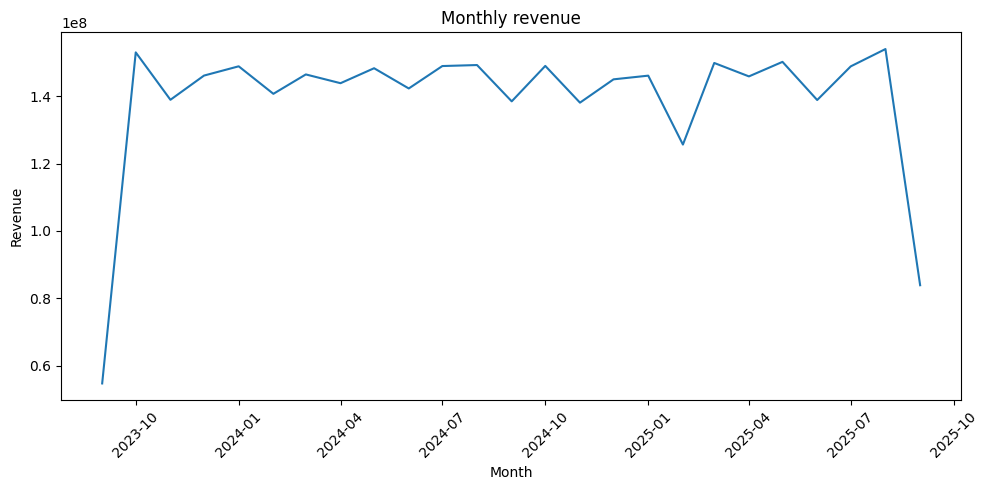

In [9]:
# KPIs
total_revenue = df['revenue'].sum()
unique_customers = df['customer_id'].nunique()
num_orders = df['invoice_no'].nunique()


# Top products
top_products = (df.groupby('product_name')['revenue']
.sum()
.sort_values(ascending=False)
.head(10)
.reset_index())


# Revenue by month
monthly = df.groupby(df['order_date'].dt.to_period('M'))['revenue'].sum().reset_index()
monthly['order_date'] = monthly['order_date'].dt.to_timestamp()


# Plot example (matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(monthly['order_date'], monthly['revenue'])
plt.title('Monthly revenue')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
clv = df.groupby('customer_id')['revenue'].sum().reset_index().rename(columns={'revenue':'CLV'})
clv.sort_values('CLV', ascending=False).head(10)

,customer_id,CLV
4910,5910,1343068.32
2238,3238,1326304.93
2605,3605,1314385.61
3568,4568,1256147.16
6908,7908,1229427.19
6775,7775,1211403.53
1190,2190,1207242.61
1663,2663,1201254.37
4271,5271,1196784.72
1776,2776,1194996.66


In [11]:
import datetime as dt
snapshot_date = df['order_date'].max() + pd.Timedelta(days=1)


rfm = df.groupby('customer_id').agg({
'order_date': lambda x: (snapshot_date - x.max()).days,
'invoice_no': 'nunique',
'revenue': 'sum'
}).reset_index()
rfm.columns = ['customer_id','recency','frequency','monetary']


# quick look
rfm.describe()

,customer_id,recency,frequency,monetary
count,9000.000000,9000.000000,9000.000000,9.000000e+03
mean,5499.500000,13.687778,55.555556,3.860462e+05
std,2598.220545,13.159356,7.440203,1.916671e+05
min,1000.000000,1.000000,31.000000,2.502971e+04
25%,3249.750000,5.000000,51.000000,2.468842e+05
50%,5499.500000,10.000000,55.000000,3.565138e+05
75%,7749.250000,19.000000,61.000000,4.930626e+05
max,9999.000000,135.000000,86.000000,1.343068e+06


In [15]:
# create scores 1-5 using quantiles
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int) # recent -> high score
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)


rfm['RFM_score'] = rfm['r_score'].map(str) + rfm['f_score'].map(str) + rfm['m_score'].map(str)


# define simple segment map (example)
def rfm_segment(row):
    if row['r_score']>=4 and row['f_score']>=4 and row['m_score']>=4:
        return 'Champions'
    if row['r_score']>=3 and row['f_score']>=3:
        return 'Loyal'
    if row['r_score']<=2 and row['f_score']>=4:
        return 'At Risk'
        return 'Others'


rfm['segment'] = rfm.apply(rfm_segment, axis=1)
rfm['segment'].value_counts()

segment
Loyal        2601
At Risk      1311
Champions     786
Name: count, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


rfm_k = rfm[['recency','frequency','monetary']].copy()
rfm_k['monetary'] = np.log1p(rfm_k['monetary'])
rfm_k['frequency'] = np.log1p(rfm_k['frequency'])


scaler = StandardScaler()
X = scaler.fit_transform(rfm_k)


# elbow method to pick k
inertia = []
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)


# pick k visually or use silhouette
sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    sil_scores.append(silhouette_score(X, km.labels_))


# assume k=4 or chosen by scores
k = 4
km = KMeans(n_clusters=k, random_state=42).fit(X)
rfm['cluster'] = km.labels_


# analyze clusters
cluster_summary = rfm.groupby('cluster').agg({
'recency':'mean','frequency':'mean','monetary':'mean','customer_id':'count'
}).rename(columns={'customer_id':'num_customers'}).reset_index()
cluster_summary

,cluster,recency,frequency,monetary,num_customers
0,0,9.706379,62.322750,471080.026708,3433
1,1,9.364738,50.263096,427547.413956,2558
2,2,40.407080,53.544248,389661.497239,1130
3,3,10.778606,51.606173,172013.853560,1879


In [18]:
# basic checks
print("rows, cols:", df.shape)
print("unique customers:", df['customer_id'].nunique())
print("unique invoices:", df['invoice_no'].nunique())
print("total revenue:", df['revenue'].sum())
print("min quantity:", df['quantity'].min(), "min revenue:", df['revenue'].min())

# missing values
print(df.isnull().sum())

# check for negative/zero quantity or revenue
print("qty <=0 count:", (df['quantity']<=0).sum())
print("revenue <=0 count:", (df['revenue']<=0).sum())


rows, cols: (500000, 12)
unique customers: 9000
unique invoices: 500000
total revenue: 3474415539.3100004
min quantity: 1 min revenue: 8.8
invoice_no      0
order_date      0
customer_id     0
product_id      0
product_name    0
category        0
quantity        0
unit_price      0
discount        0
revenue         0
country         0
order_month     0
dtype: int64
qty <=0 count: 0
revenue <=0 count: 0


In [20]:
import os
os.makedirs("data", exist_ok=True)


In [21]:
df.to_csv("data/cleaned_retail.csv", index=False)
rfm.to_csv("data/rfm_table.csv", index=False)


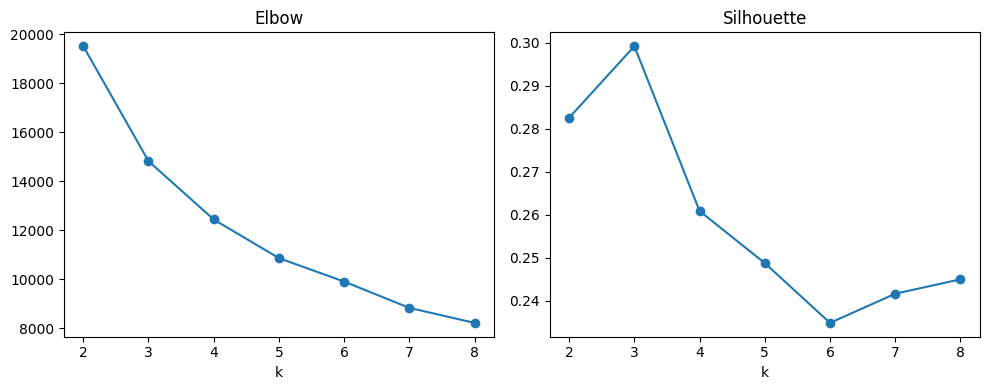

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# X already scaled (from guide): X
inertia, sil = [], []
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X, km.labels_))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, '-o'); plt.title('Elbow'); plt.xlabel('k')
plt.subplot(1,2,2)
plt.plot(K, sil, '-o'); plt.title('Silhouette'); plt.xlabel('k'); plt.tight_layout()
plt.show()

In [24]:
import os
os.makedirs("models", exist_ok=True)

from joblib import dump
dump(km, "models/kmeans_model.joblib")


['models/kmeans_model.joblib']

In [25]:
import pandas as pd
try:
    rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int)
except ValueError:
    rfm['r_score'] = pd.cut(rfm['recency'], bins=5, labels=[5,4,3,2,1]).astype(int)
# similar fallback for f_score, m_score

In [26]:
# top 20% revenue share
cust_rev = df.groupby('customer_id')['revenue'].sum().reset_index().sort_values('revenue', ascending=False)
top20 = int(0.2 * len(cust_rev))
pct = cust_rev.head(top20)['revenue'].sum() / cust_rev['revenue'].sum() * 100
print(f"Top 20% customers account for {pct:.1f}% of revenue")

# top 10 products by revenue
print(df.groupby('product_name')['revenue'].sum().sort_values(ascending=False).head(10))

Top 20% customers account for 35.4% of revenue
product_name
Electronics Item 20    1.221426e+08
Electronics Item 7     1.177599e+08
Electronics Item 34    1.167653e+08
Electronics Item 1     1.124900e+08
Electronics Item 17    1.120917e+08
Electronics Item 37    1.071089e+08
Electronics Item 2     1.069374e+08
Electronics Item 32    1.069137e+08
Electronics Item 48    1.030638e+08
Electronics Item 14    9.959275e+07
Name: revenue, dtype: float64


In [32]:
print(df.columns.tolist())





['invoice_no', 'order_date', 'customer_id', 'product_id', 'product_name', 'category', 'quantity', 'unit_price', 'discount', 'revenue', 'country', 'order_month']


In [33]:
import pandas as pd

# Load cleaned data
df = pd.read_csv("data/cleaned_retail.csv")

# Ensure order_date is datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Reference date (1 day after last purchase)
ref_date = df['order_date'].max() + pd.Timedelta(days=1)

# Build RFM
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (ref_date - x.max()).days,  # Recency
    'invoice_no': 'nunique',                            # Frequency
    'revenue': 'sum'                                    # Monetary
}).reset_index()

# Rename columns
rfm.rename(columns={
    'order_date': 'Recency',
    'invoice_no': 'Frequency',
    'revenue': 'Monetary'
}, inplace=True)

print(rfm.head())



   customer_id  Recency  Frequency   Monetary
0         1000       19         64  348171.55
1         1001       22         62  118961.28
2         1002        1         60  289007.24
3         1003        1         60  339780.70
4         1004       11         46  113814.00


In [34]:
rfm['cluster'] = km.predict(rfm[['Recency', 'Frequency', 'Monetary']])
rfm.to_csv("data/rfm_with_clusters.csv", index=False)


C:\Users\yadav\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [35]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
km.fit(X)   # instead of converting to numpy


,n_clusters,8
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [36]:
rfm['cluster'] = km.predict(X)


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select RFM features
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the data (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train KMeans (let’s start with 4 clusters)
km = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['cluster'] = km.fit_predict(X_scaled)

# Save clustered RFM data
rfm.to_csv("data/rfm_with_clusters.csv", index=False)

print(rfm['cluster'].value_counts())


cluster
2    3362
1    2763
0    1718
3    1157
Name: count, dtype: int64


In [38]:
cluster_summary = rfm.groupby('cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

print(cluster_summary)

        Recency Frequency   Monetary      
           mean      mean       mean count
cluster                                   
0         10.60     58.50  674730.92  1718
1          9.52     62.02  343987.17  2763
2          9.64     49.60  281436.10  3362
3         39.98     53.07  361800.46  1157


In [39]:
import os
from joblib import dump

os.makedirs("models", exist_ok=True)
dump(km, "models/kmeans_model.joblib")

['models/kmeans_model.joblib']

In [40]:
# 1. Cleaned transactions
df.to_csv("data/cleaned_retail.csv", index=False)

# 2. RFM with clusters
rfm.to_csv("data/rfm_with_clusters.csv", index=False)

# 3. Cluster summary (profiling)
cluster_summary = rfm.groupby('cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

cluster_summary.to_csv("data/cluster_summary.csv")
